# Survival Analysis on a Cohort of Phenopackets
This notebook illustrates how to load in a cohort of phenopackets (generated by the [oncoexporter](https://github.com/monarch-initiative/oncoexporter) package) and perform survival analysis on it using the [lifelines](https://lifelines.readthedocs.io/en/latest/) package.


In [6]:
import os
import pandas as pd
import warnings
import typing
import re
from google.protobuf.json_format import Parse
from phenopackets import Phenopacket

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica' 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = 'black'

## Load a cohort of Phenopackets

In [2]:
'''
Load a cohort of phenopackets
'''
def _load_phenopacket(phenopacket_path: str) -> Phenopacket:
    with open(phenopacket_path) as f:
        return Parse(f.read(), Phenopacket())

def load_phenopacket_dir(pp_dir: str) -> typing.Sequence[Phenopacket]:
    patients = []
    for patient_file in os.listdir(pp_dir):
        if patient_file.endswith('.json'):
            phenopacket_path = os.path.join(pp_dir, patient_file)
            pp = _load_phenopacket(phenopacket_path)
            patients.append(pp)

    return patients

fpath_pp_dir = '/Users/sierkml/data/phenopackets/' 

cohort = "Brain"
fpath_cohort_dir = fpath_pp_dir + cohort

pps = load_phenopacket_dir(fpath_cohort_dir)
print("Loaded", len(pps), "phenopackets from", fpath_cohort_dir)

Loaded 1394 phenopackets from /Users/sierkml/data/phenopackets/Brain


## Convert phenopackets to a dataframe

In [ ]:
'''
Convert phenopackets to a dataframe for use in lifelines package
'''
def get_years_from_iso8601duration(iso8601):
    
    # deal with P#Y#M#D format
    # expect, e.g., P55Y6M or P11355D
    # strip P, Y and M
    years, months, days = '', '', ''
    try:
        # get years from P[number]Y
        #years = iso8601.split('Y')[0].split('P')[1]
        #months = iso8601.split('M')[0].split('Y')[1]
        #days = iso8601.split('D')[0].split('')
        
        if re.search('Y', iso8601):
            years = re.split('^P(\d+)Y',iso8601)[1]
        if re.search('M', iso8601):
            months = re.split('^P.*(\d+)M',iso8601)[1]
        if re.search('^P\d+D$', iso8601):
            days = re.split('^P(\d+)D$',iso8601)[1]
        
        years = float(years) if years != '' else 0
        
        if months != '': 
            try:
                years += float(months) / 12
            except TypeError:
                raise Exception(f'Could not parse months: {months}')
        
        if days != '':
            try:
                years += float(days) / 365.25
            except TypeError:
                raise Exception(f'Could not parse days: {days}')
        
    except TypeError:
        raise Exception(f'Could not parse age string: {iso8601}')
    
    return float(years)         

def generate_dataframe(pps):
    '''
    need to go through each phenopacket and generate a dataframe with the following fields:
        subjectID age sex vital_status surival_time disease stage variants
    '''
    rows_list = []
    cnt = 0
    for pp in pps:
        cnt += 1
        #print("\n\n", cnt, ">>>>>>>>> Subject <<<<<<<<<<<")
        pid = pp.subject.id
        sex = pp.subject.sex
        #print(pid)
        vital_status = pp.subject.vital_status.status
        survival_time = pp.subject.vital_status.survival_time_in_days
        #print(vital_status, survival_time)
        
        if pp.diseases:
            #print(pp.diseases)
            disease = pp.diseases[0].term.label
            #print(pp.diseases[0].primary_site.label)
            if pp.diseases[0].disease_stage is not None:
                #print(pp.diseases[0].disease_stage)
                stage = pp.diseases[0].disease_stage[0].label
            else:
                stage = 'Unknown'
        else:
            disease = 'Unknown'
            stage = 'Unknown'
            
        age_str = pp.subject.time_at_last_encounter.age.iso8601duration
        try:
            duration = pd.to_timedelta(age_str) # nan if no value in pp
            age_in_years = duration.days / 365.25
        
        except ValueError:
            warnings.warn(f"Could not parse age string with pandas, using manual approach: {age_str}")
            age_in_years = get_years_from_iso8601duration(age_str)
        if age_in_years == 'nan':
            age_in_years = 0
        #print("age:", age_in_years)
        
        # variants
        # get a list of comma-separated values with symbol:protein_id:p.mutation (e.g. DACH2:ENSP00000362217:p.P19S)
        variants = []
        gene_symbol = []
        if pp.interpretations:
            #print(pp.interpretations)
            for i in pp.interpretations:
                if i.diagnosis:
                    if i.diagnosis.genomic_interpretations:
                        for g in i.diagnosis.genomic_interpretations:
                            #print(g)
                            gene_symbol = 'Unknown'
                            if g.variant_interpretation.variation_descriptor.gene_context:
                                gene_symbol = g.variant_interpretation.variation_descriptor.gene_context.symbol
                            for v in g.variant_interpretation.variation_descriptor.expressions:
                                #print(v)
                                if v.syntax == 'hgvs.p':
                                    variants.append(gene_symbol + ":" + v.value)
                            
        dict = {}
        dict.update(subjectID = pid, 
                    age = age_in_years, 
                    sex = sex, 
                    vital_status = vital_status, 
                    survival_time = survival_time, 
                    disease = disease, 
                    stage = stage, 
                    variants = variants)
        rows_list.append(dict)
        
    df = pd.DataFrame(rows_list)
    return(df)

df = generate_dataframe(pps)
df.head()        


,subjectID,age,sex,vital_status,survival_time,disease,stage,variants
0,TCGA.TCGA-06-0131,NaN,0,0,0,Brain Glioblastoma,Stage Unknown,[]
1,TCGA.TCGA-19-2623,65.256674,2,1,229,Brain Glioblastoma,Stage Unknown,"[ANKAR:ENSP00000407459:p.I440L, ANKAR:ENSP0000..."
2,TCGA.TCGA-14-1453,69.259411,2,2,35,Brain Glioblastoma,Stage Unknown,"[PLEKHG2:ENSP00000205135:p.G32=, PLEKHG2:ENSP0..."
3,CPTAC.C3L-01327,74.360027,2,2,646,Brain Glioblastoma,Stage Unknown,"[LY75:ENSP00000263636:p.S878=, DHH:ENSP0000049..."
4,TCGA.TCGA-HT-8109,64.301164,2,1,169,Anaplastic Oligodendroglioma,Stage Unknown,"[ATF7IP:ENSP00000444589:p.V1086=, ATF7IP:ENSP0..."


## Filter dataframe 
We filter the dataframe to only include patients with vital_status available, and we specify the gene and position or specific mutation to analyze.  
TODO: Allow more types of filtering, and multiple genes/mutations to be specified

In [4]:
'''
Filter the dataframe based on survival data and mutation presence
'''

gene_of_interest = "IDH1" # EGFR
mutation_of_interest = "All" # All or L858R or Position:858

def filter_df(df, gene_of_interest, mutation_of_interest):
    
    #['GAPVD1:ENSP00000377665:p.I204V', 'GAPVD1:ENSP00000391251:p.I35V', 'GAPVD1:ENSP00000377664:p.I204V', 'GAPVD1:ENSP00000377646:p.I204V']
    def get_gene_variant(vars, GoI, MoI):
        for var in vars:
            v = var.split(':')
            if v[0] == GoI:
                if MoI == "All": # any mutation in gene
                    return(1)
                elif re.match(r"^Position", MoI):
                    mut = v[2].split('.')[1]
                    if re.match(r"\w(\d+)\w", mut).group(1) == MoI.split(':')[1]: # any mutation at position
                        return(1)
                else:
                    if v[2].split('.')[1] == MoI: # only specific mutation
                        return(1)

    # remove rows with no survival data
    df2 = df[df['vital_status'] > 0].copy()
    
    # need to convert vital status from 1,2 to 0,1 for plotting
    df2['vital_status'] = df2['vital_status'].replace({1:0, 2:1})  
    print("Full df: ", df.shape)
    print("Filtered vital status: ", df2.shape)

    # select for specific disease
    #df2 = df2['disease'] == 'Non Small Cell Lung Cancer'
    
    df2['known_mutation'] = df2['variants'].apply(lambda x: 1 if get_gene_variant(x, gene_of_interest, mutation_of_interest) else 0) 
        
    return(df2)

df2 = filter_df(df, gene_of_interest, mutation_of_interest)
mutated = (df2['known_mutation'] == 1)
not_mutated = (df2['known_mutation'] == 0)

n_mut = len(df2.survival_time[mutated])
n_not_mut = len(df2.survival_time[not_mutated])

if n_mut == 0:
    print(f"No {gene_of_interest} {mutation_of_interest} mutations found in the cohort.")
df2.head()

Full df:  (1394, 8)
Filtered vital status:  (1337, 8)


,subjectID,age,sex,vital_status,survival_time,disease,stage,variants,known_mutation
1,TCGA.TCGA-19-2623,65.256674,2,0,229,Brain Glioblastoma,Stage Unknown,"[ANKAR:ENSP00000407459:p.I440L, ANKAR:ENSP0000...",0
2,TCGA.TCGA-14-1453,69.259411,2,1,35,Brain Glioblastoma,Stage Unknown,"[PLEKHG2:ENSP00000205135:p.G32=, PLEKHG2:ENSP0...",0
3,CPTAC.C3L-01327,74.360027,2,1,646,Brain Glioblastoma,Stage Unknown,"[LY75:ENSP00000263636:p.S878=, DHH:ENSP0000049...",0
4,TCGA.TCGA-HT-8109,64.301164,2,0,169,Anaplastic Oligodendroglioma,Stage Unknown,"[ATF7IP:ENSP00000444589:p.V1086=, ATF7IP:ENSP0...",1
5,TCGA.TCGA-WY-A85C,36.977413,2,0,1426,"Astrocytoma, Not Otherwise Specified",Stage Unknown,"[CHD4:ENSP00000496233:p.V253I, CHD4:ENSP000004...",1


## Plot the Kaplan-Meier Curve and perform a logrank test

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         421.46 <0.005    308.71

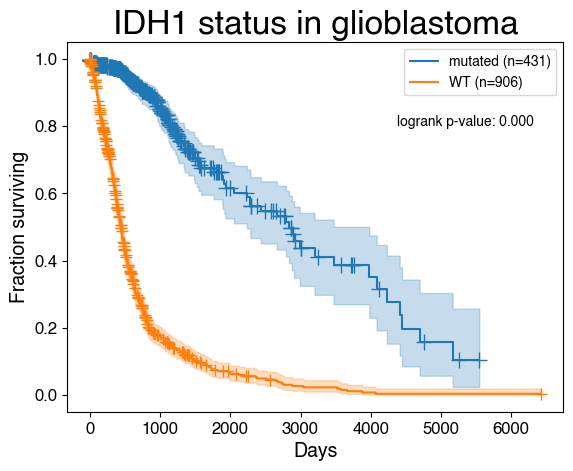

In [ ]:
'''
Plot Kaplan-Meier Curve
see https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
'''

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt 

ax = plt.subplot(111)

kmf = KaplanMeierFitter(label="Mutation survival probability")

#title = cohort + " cancer survival"
title = "IDH1 status in glioblastoma"

#label_mut = cohort + " survival (" + gene_of_interest + " " + mutation_of_interest + " (n=" + str(n_mut) + "))"
label_mut = "mutated " + "(n=" + str(n_mut) + ")"

#label_nonmut = cohort + " survival (no mutation (n=" + str(n_not_mut) + "))"
label_nonmut = "WT " + "(n=" + str(n_not_mut) + ")"

kmf.fit(durations=df2.survival_time[mutated],event_observed=df2.vital_status[mutated], label=label_mut)
kmf.plot(ax=ax, show_censors=True) # censor_styles={"marker": "o", "ms": 60}

kmf.fit(df2.survival_time[not_mutated],df2.vital_status[not_mutated], label=label_nonmut)
kmf.plot(ax=ax, show_censors=True, censor_styles={"marker": "+", "ms": 8})
plt.title(title, fontsize=24)

# get logrank p-value
results = logrank_test(df2.survival_time[mutated], df2.survival_time[not_mutated], 
                       df2.vital_status[mutated], df2.vital_status[not_mutated], alpha=.05)
results.print_summary()

x_coord = max(df2.survival_time)*0.68
ax.text(x_coord,0.8,f"logrank p-value: {results.p_value:.3f}") 
ax.set_xlabel("Days")
ax.set_ylabel("Fraction surviving")
ax.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True) # optional
#add_at_risk_counts(kmf, ax=ax) # optional
#plt.show()
#plt.savefig(cohort + " (" + gene_of_interest + " " + mutation_of_interest + ")" + "kmf_plot.png", format="png"); # optional
plt.savefig("Glioblastoma_IDH1_KM.png", dpi=300)


## Perform Cox Proportional Hazards analysis

<lifelines.CoxPHFitter: fitted with 1335 total observations, 556 right-censored observations>
             duration col = 'survival_time'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 1335
number of events observed = 779
   partial log-likelihood = -4583.45
         time fit was run = 2024-11-05 20:09:43 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
age             0.03      1.03      0.00            0.03            0.04                1.03                1.04
sex             0.10      1.10      0.07           -0.05            0.24                0.96                1.28
known_mutation -1.63      0.20      0.12           -1.87           -1.39                0.15                0.25

                cmp to      z      p  -log2(p)
covariate                                     
age               0.00  11.41 <0.005     97.70
sex               0.00   1.34   0.18      2.47
known_mutation    0.00 -13.49 <0.005    135.41
---
Concordance = 0.76
Partial AIC = 9172.90
log-likelihood ratio test = 625.54 on 3 df
-log2(p) of ll-ratio test = 446.91

<Axes: xlabel='HR (95% CI)'>

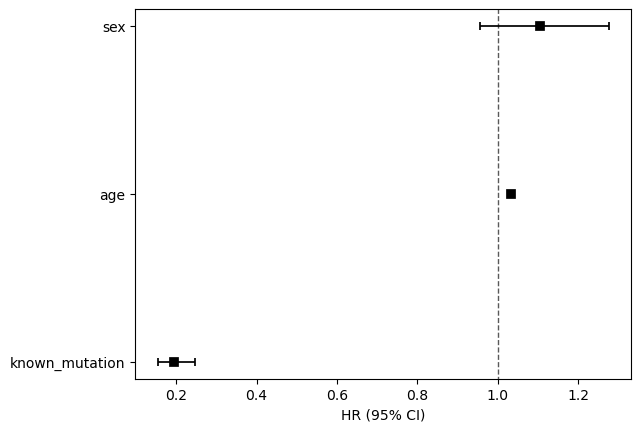

In [28]:
%matplotlib inline
from lifelines import CoxPHFitter
# all columns need to be numeric for CoxPHFitter
# make subjectID the index, convert age to integer, drop disease and stage
#df.set_index('subjectID')
df_cox = df2.drop(['subjectID', 'disease', 'stage', 'variants'], axis=1)
df_cox.dropna(inplace=True)
df_cox.shape
df_cox.head()

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='survival_time', event_col='vital_status')
cph.print_summary()
cph.plot(markerfacecolor='black', hazard_ratios=True)
